In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import xgboost
import xgboost as xgb

# import sklearn regression models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
 

In [2]:
df = pd.read_csv('BANES_weather_merged.csv', parse_dates=['time'])
df.head()


,time,location,postcode,energy,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco
0,2006-10-01 00:30:00,Guildhall Electricity Supply 1 (HH),BA1 5AW,32.8,14.95,13.80,93.0,0.0,0.0,175.0,13.9,NaN,1001.8,NaN
1,2006-10-01 00:30:00,Guildhall Electricity Supply 1 (HH),BA1 5AW,32.8,14.95,13.80,93.0,0.0,0.0,175.0,13.9,NaN,1001.8,NaN
2,2006-10-01 01:00:00,Guildhall Electricity Supply 1 (HH),BA1 5AW,33.0,14.80,13.50,92.0,0.0,0.0,180.0,14.8,NaN,1001.7,NaN
3,2006-10-01 01:00:00,Guildhall Electricity Supply 1 (HH),BA1 5AW,33.0,14.80,13.50,92.0,0.0,0.0,180.0,14.8,NaN,1001.7,NaN
4,2006-10-01 01:30:00,Bath Central Library Electricity (HH),BA1 5AL,5.9,14.75,13.35,91.5,0.0,0.0,180.0,13.9,NaN,1001.7,NaN


In [3]:
# remove duplicate rows
df = df.groupby(['time', 'location', 'postcode']).mean().reset_index()

# remove unnecessary columns
df = df.drop(['dwpt', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'coco'], axis=1)

# add column for day of week, day of year, hour of day
df['day_of_week'] = df['time'].dt.dayofweek
df['day_of_year'] = df['time'].dt.dayofyear
df['hour_of_day'] = df['time'].dt.hour

df.describe()


,energy,temp,rhum,pres,day_of_week,day_of_year,hour_of_day
count,5.029973e+06,5.029973e+06,5.029973e+06,5.029973e+06,5.029973e+06,5.029973e+06,5.029973e+06
mean,4.070574e+00,1.062729e+01,8.369049e+01,1.015109e+03,2.993236e+00,1.858417e+02,1.150156e+01
std,8.549472e+00,5.350319e+00,1.285504e+01,1.100528e+01,1.998529e+00,1.062980e+02,6.922638e+00
min,0.000000e+00,-9.400000e+00,1.500000e+01,9.602000e+02,0.000000e+00,1.000000e+00,0.000000e+00
25%,2.140000e-01,6.600000e+00,7.700000e+01,1.008700e+03,1.000000e+00,9.400000e+01,6.000000e+00
50%,7.500000e-01,1.060000e+01,8.700000e+01,1.016100e+03,3.000000e+00,1.890000e+02,1.200000e+01
75%,3.240000e+00,1.460000e+01,9.300000e+01,1.022500e+03,5.000000e+00,2.780000e+02,1.800000e+01
max,7.470000e+01,3.160000e+01,1.000000e+02,1.048900e+03,6.000000e+00,3.660000e+02,2.300000e+01


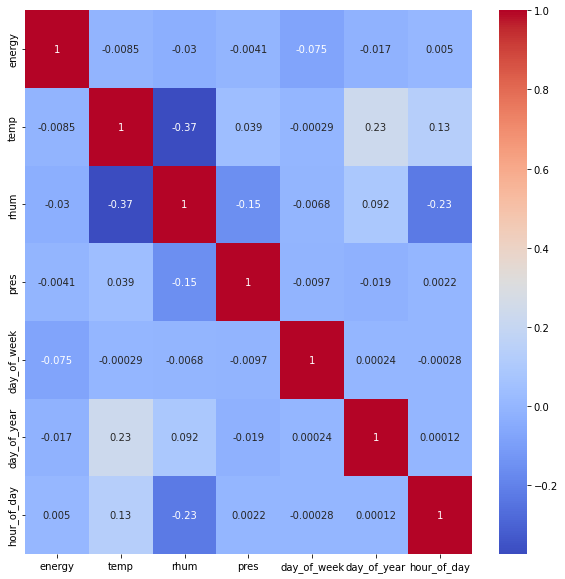

In [4]:
# correlation matrix
corr = df.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


None of the features has a large correlation with the `energy` target.

We will check this again with the daily `energy` data.

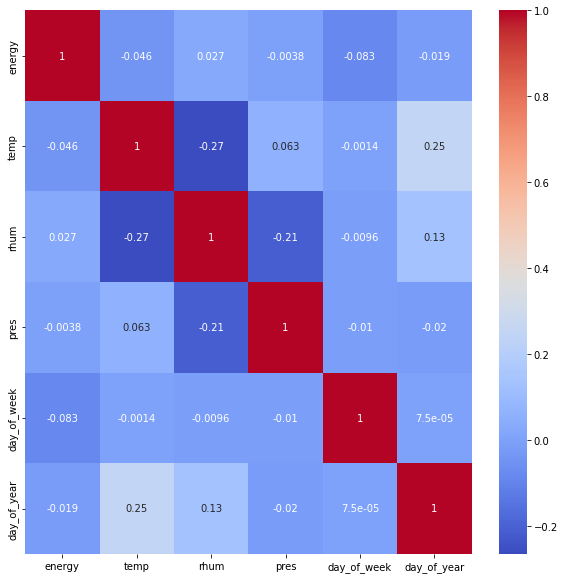

In [5]:
df_daily = df.copy()

# data is half hourly, so we need to aggregate to daily
df_daily['day'] = df_daily['time'].dt.day
df_daily['month'] = df_daily['time'].dt.month
df_daily['year'] = df_daily['time'].dt.year

df_daily = df_daily.groupby(['day', 'month', 'year', 'location', 'postcode']).mean().reset_index()

df_daily.drop(['day', 'month', 'year', 'hour_of_day'], axis=1, inplace=True)

plt.figure(figsize=(10, 10))
sns.heatmap(df_daily.corr(), annot=True, cmap='coolwarm')
plt.show()


This does not appear to be any better.

Let's try with a single location.

Guildhall Electricity Supply 1 (HH)


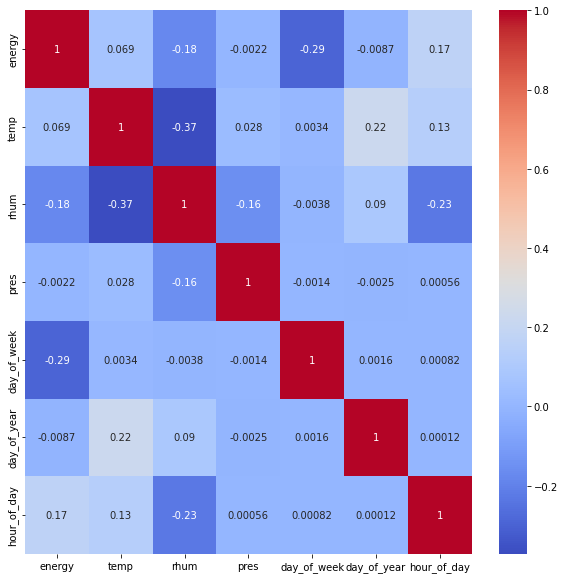

In [6]:
# location that has the most data
max_location = df['location'].value_counts().idxmax()
print(max_location)

df_max_location = df[df['location'] == max_location]

plt.figure(figsize=(10, 10))
sns.heatmap(df_max_location.corr(), annot=True, cmap='coolwarm')
plt.show()


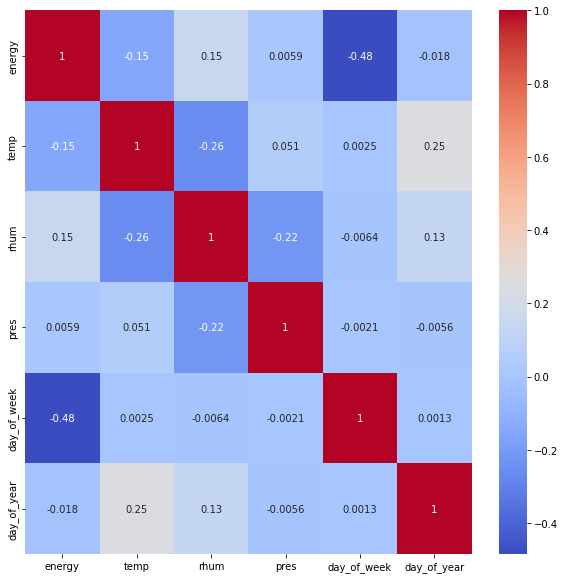

In [7]:
df_daily_max_location = df_daily[df_daily['location'] == max_location]

plt.figure(figsize=(10, 10))
sns.heatmap(df_daily_max_location.corr(), annot=True, cmap='coolwarm')
plt.show()


There are no significant correlations between the features and the `energy` target. `Humidity` and `hour of day` are the most correlated.

`Day of week` is the least correlated. What if we only use the `is_weekend` feature?

C:\Users\migue\AppData\Local\Temp/ipykernel_46188/1324663626.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_max_location['is_weekend'] = df_daily_max_location['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)


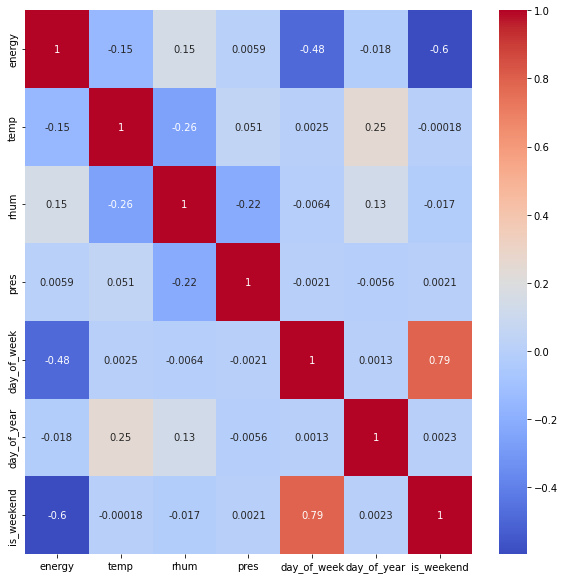

In [8]:
df_daily_max_location['is_weekend'] = df_daily_max_location['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)

plt.figure(figsize=(10, 10))
sns.heatmap(df_daily_max_location.corr(), annot=True, cmap='coolwarm')
plt.show()


It was also not better.

Now we will see how the previous values of `energy` correlate with the `energy` target.

In [9]:
# parse the time column to only have the date
df_daily = df.copy()
df_daily['date'] = df_daily['time'].dt.date

df_daily = df_daily.groupby(['date', 'location', 'postcode']).mean().reset_index()
df_daily.drop(['hour_of_day', 'postcode'], axis=1, inplace=True)

# parse day_of_week and day_of_year to integers
df_daily['day_of_week'] = df_daily['day_of_week'].astype(int)
df_daily['day_of_year'] = df_daily['day_of_year'].astype(int)

df_daily.head()

,date,location,energy,temp,rhum,pres,day_of_week,day_of_year
0,2006-10-01,Bath Central Library Electricity (HH),15.935897,14.607692,85.012821,1000.308974,6,274
1,2006-10-01,Guildhall Electricity Supply 1 (HH),30.353846,14.689744,85.756410,1000.457692,6,274
2,2006-10-02,Bath Central Library Electricity (HH),29.792105,13.684211,84.776316,1002.405263,0,275
3,2006-10-02,Guildhall Electricity Supply 1 (HH),42.156410,13.884615,83.512821,1002.283333,0,275
4,2006-10-03,Bath Central Library Electricity (HH),31.489474,11.868421,78.881579,1004.919737,1,276


In [10]:
df_10_days = df_daily.copy()

# order the data by date and location
df_10_days = df_10_days.groupby(['date', 'location']).mean().reset_index().sort_values(['location', 'date'])

# create a new column for the last 10 days energy consumption
for i in range(1, 11):
    df_10_days[f'energy_{i}'] = df_10_days.shift(i)['energy']

# df_10_days.dropna(inplace=True)
df_10_days.head()


,date,location,energy,temp,rhum,pres,day_of_week,day_of_year,energy_1,energy_2,energy_3,energy_4,energy_5,energy_6,energy_7,energy_8,energy_9,energy_10
2351,2008-06-14,## OLD Paulton Library Electricity Supply 1,0.185806,13.196774,70.000000,1016.006452,5.0,166.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2364,2008-06-15,## OLD Paulton Library Electricity Supply 1,0.077188,13.350000,70.375000,1011.621875,6.0,167.0,0.185806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2377,2008-06-16,## OLD Paulton Library Electricity Supply 1,0.076452,13.051613,68.887097,1011.801613,0.0,168.0,0.077188,0.185806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2390,2008-06-17,## OLD Paulton Library Electricity Supply 1,0.220323,12.977419,72.564516,1012.485484,1.0,169.0,0.076452,0.077188,0.185806,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2403,2008-06-18,## OLD Paulton Library Electricity Supply 1,0.078000,13.433333,88.600000,1010.003333,2.0,170.0,0.220323,0.076452,0.077188,0.185806,NaN,NaN,NaN,NaN,NaN,NaN


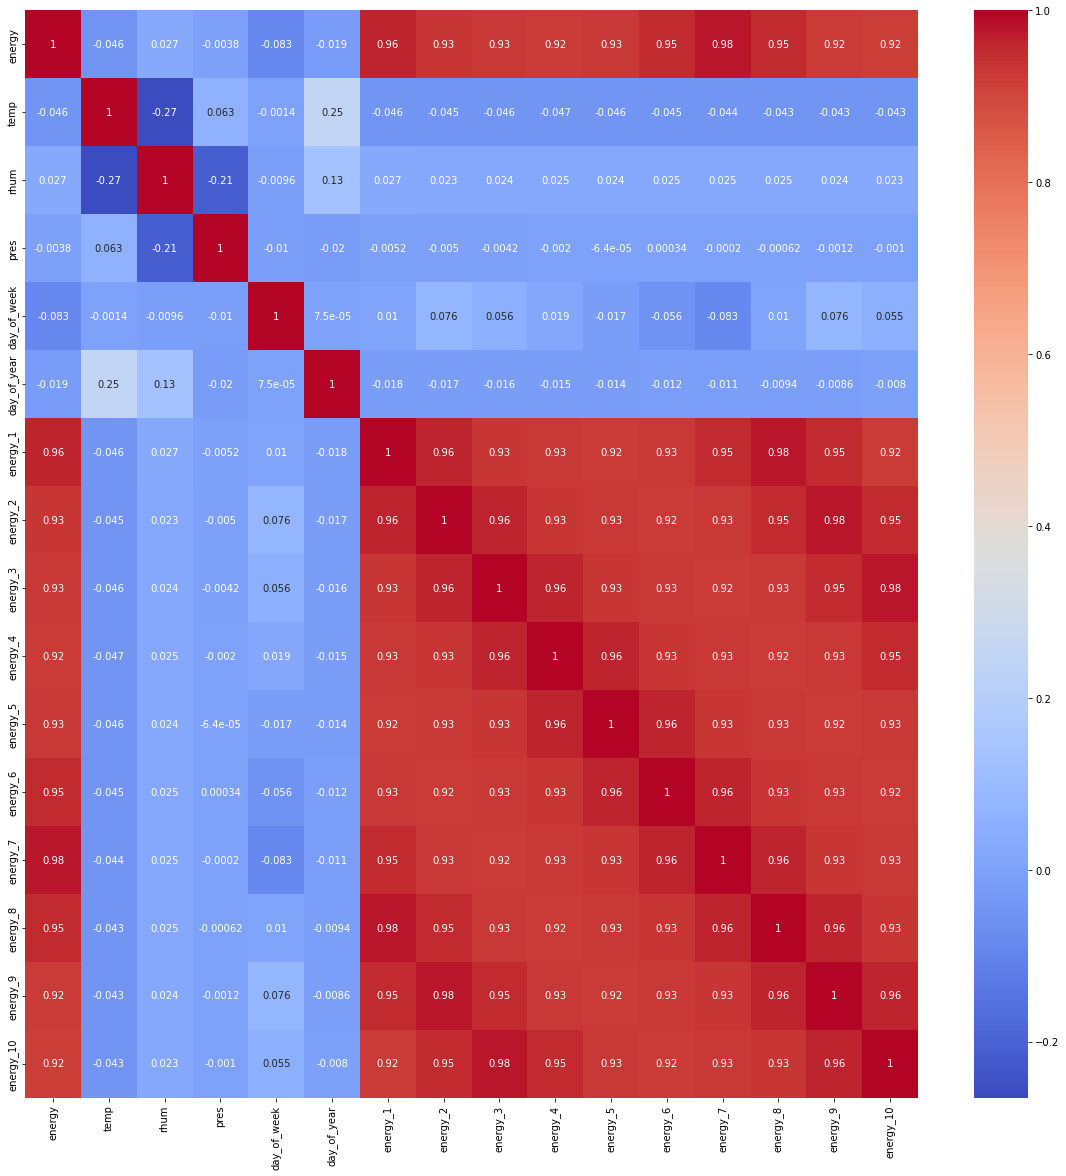

In [11]:
plt.figure(figsize=(20, 20))
sns.heatmap(df_10_days.corr(), annot=True, cmap='coolwarm')
plt.show()


In [12]:
df_24_hours = df.copy()

# order the data by time and location
df_24_hours = df_24_hours.groupby(['time', 'location']).mean().reset_index().sort_values(['location', 'time'])

for i in range(1, 49):  # 49 because there are 48 / 2 hours in a day (data is half hourly)
    df_24_hours[f'energy_{i}'] = df_24_hours.shift(i)['energy']

# df_24_hours.dropna(inplace=True)
df_24_hours.head()


,time,location,energy,temp,rhum,pres,day_of_week,day_of_year,hour_of_day,energy_1,...,energy_39,energy_40,energy_41,energy_42,energy_43,energy_44,energy_45,energy_46,energy_47,energy_48
78311,2008-06-14 00:30:00,## OLD Paulton Library Electricity Supply 1,0.08,9.6,81.0,1017.75,5.0,166.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78321,2008-06-14 01:00:00,## OLD Paulton Library Electricity Supply 1,0.07,9.6,81.0,1017.60,5.0,166.0,1.0,0.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78346,2008-06-14 02:30:00,## OLD Paulton Library Electricity Supply 1,0.08,9.1,81.0,1017.45,5.0,166.0,2.0,0.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78355,2008-06-14 03:00:00,## OLD Paulton Library Electricity Supply 1,0.07,8.6,81.0,1017.40,5.0,166.0,3.0,0.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78374,2008-06-14 04:00:00,## OLD Paulton Library Electricity Supply 1,0.07,8.6,81.0,1016.90,5.0,166.0,4.0,0.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


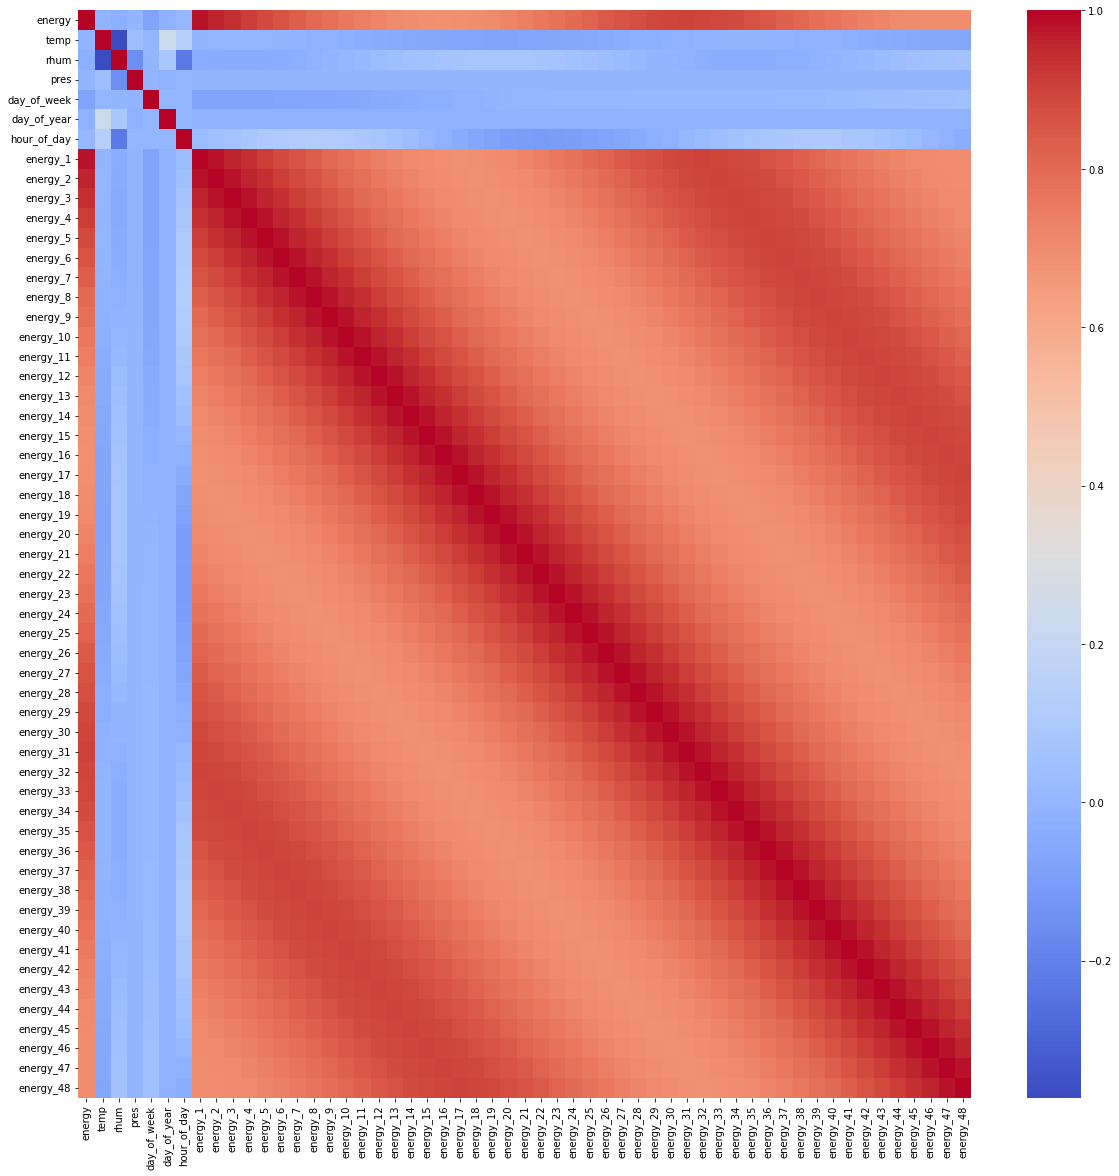

In [14]:
plt.figure(figsize=(20, 20))
sns.heatmap(df_24_hours.corr(), cmap='coolwarm')
plt.show()


From this correlation graphic, we can see that the `energy` target has a positive correlation with the previous values of `energy`.